In [44]:
# Import necessary libraries
import pandas as pd
import numpy as np
import glob
import re
from tqdm import tqdm

import plotly.graph_objects as go

# proprocessing
from sklearn import preprocessing
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout,Activation 
from keras.layers import LSTM
from keras.models import load_model
import matplotlib.pyplot as plt
import h5py
import datetime
import tensorflow as tf

In [45]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [46]:
def downsample_dataframe(df, downsampling_frequency, fill_method='mean'):
  """
  Downsamples a DataFrame and fills missing values.

  Args:
    df: The DataFrame to downsample.
    downsampling_frequency: The frequency to downsample the DataFrame to.
    fill_method: The method to use to fill missing values.

  Returns:
    The downsampled DataFrame.
  """

  # Convert the Timestamp column to a datetime object.
  df['Timestamp'] = pd.to_datetime(df['Timestamp'])

  # Set the index of the DataFrame to the Timestamp column.
  df = df.set_index('Timestamp')

  # Fill the missing values.
  if fill_method == 'mean':
    df = df.fillna(df.mean())
  elif fill_method == 'median':
    df = df.fillna(df.median())
  else:
    raise ValueError('Invalid fill_method: {}'.format(fill_method))

  # Downsample the DataFrame.
  df = df.resample(downsampling_frequency).mean()
  return df
  # Check if any missing values were created after downsampling.
  if df.isna().any():
    df = df.fillna(df.mean())

  return df





In [47]:
path_lists = glob.glob('GreenD_reduced_version_03/'+'*.csv')
sorted_file_paths = sorted(path_lists)
def extract_digits(string):
    # Extract digits from the string using regular expression
    digits = re.findall(r'\d+', string)
    return int(digits[0]) if digits else 0

sorted_file_paths = sorted(path_lists, key=extract_digits)
print(sorted_file_paths)

conct_list = []
for path in tqdm(sorted_file_paths ,desc='processing'):
    
    data = pd.read_csv(path)
    data['Timestamp'] = pd.to_datetime(data['Timestamp'],utc=True,unit='s')#format='%Y-%m-%d %H-%M-%S')
    data['Timestamp'] = data['Timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
    conct_list.append(data)
!mkdir 'Combined-Dataset-version-03'
df = pd.concat(conct_list)


['GreenD_reduced_version_03/greend_dataset_466.csv', 'GreenD_reduced_version_03/greend_dataset_341.csv', 'GreenD_reduced_version_03/greend_dataset_137.csv', 'GreenD_reduced_version_03/greend_dataset_32.csv', 'GreenD_reduced_version_03/greend_dataset_370.csv', 'GreenD_reduced_version_03/greend_dataset_35.csv', 'GreenD_reduced_version_03/greend_dataset_180.csv', 'GreenD_reduced_version_03/greend_dataset_204.csv', 'GreenD_reduced_version_03/greend_dataset_114.csv', 'GreenD_reduced_version_03/greend_dataset_377.csv', 'GreenD_reduced_version_03/greend_dataset_338.csv', 'GreenD_reduced_version_03/greend_dataset_179.csv', 'GreenD_reduced_version_03/greend_dataset_363.csv', 'GreenD_reduced_version_03/greend_dataset_80.csv', 'GreenD_reduced_version_03/greend_dataset_78.csv', 'GreenD_reduced_version_03/greend_dataset_464.csv', 'GreenD_reduced_version_03/greend_dataset_74.csv', 'GreenD_reduced_version_03/greend_dataset_365.csv', 'GreenD_reduced_version_03/greend_dataset_387.csv', 'GreenD_reduced_

processing: 100%|██████████| 472/472 [00:31<00:00, 14.87it/s]


mkdir: cannot create directory ‘Combined-Dataset-version-03’: File exists


In [48]:


# Downsample the DataFrame to 1-hour frequency and fill missing values using mean imputation.
df_1_hour = downsample_dataframe(df, '1H', fill_method='mean')
df_1_hour.reset_index('Timestamp',inplace=True)
df_1_hour.fillna(method='ffill',inplace=True)

# Downsample the DataFrame to 15-minute frequency and fill missing values using median imputation.
# df_15_min = downsample_dataframe(df, '15T', fill_method='mean')
# df_15_min.reset_index('Timestamp',inplace=True)
# df_15_min.fillna(method='ffill',inplace=True)

# Downsample the DataFrame to 30-minute frequency and fill missing values using median imputation.
# df_30_min = downsample_dataframe(df, '30T', fill_method='mean')
# df_30_min.reset_index('Timestamp',inplace=True)
# df_30_min.fillna(method='ffill',inplace=True)

# Downsample the DataFrame to 1 Day frequency and fill missing values using median imputation.
# df_1_day = downsample_dataframe(df, '1d', fill_method='mean')
# df_1_day.reset_index('Timestamp',inplace=True)
# df_1_day.fillna(method='ffill',inplace=True)

# Downsample the DataFrame to 7 Day frequency and fill missing values using median imputation.
# df_7_day = downsample_dataframe(df, '7d', fill_method='mean')
# df_7_day.reset_index('Timestamp',inplace=True)
# df_7_day.fillna(method='ffill',inplace=True)

In [49]:
df_1_hour

,Timestamp,Summe
0,2014-03-12 07:00:00,66.321410
1,2014-03-12 08:00:00,14.977094
2,2014-03-12 09:00:00,27.099825
3,2014-03-12 10:00:00,14.787116
4,2014-03-12 11:00:00,27.785160
...,...,...
11386,2015-06-29 17:00:00,80.591582
11387,2015-06-29 18:00:00,52.420814
11388,2015-06-29 19:00:00,46.189453
11389,2015-06-29 20:00:00,58.697892


In [50]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=15):
    """_summary_

    Args:
        dataset (_type_): _description_
        look_back (int, optional): _description_. Defaults to 15.

    Returns:
        _type_: _description_
    """
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
        # print('Value of a : {}'.format(a))
        # print('Value of y : {}'.format(dataset[i + look_back, 0]))
    return np.array(dataX), np.array(dataY)

In [51]:
data_df = df_1_hour

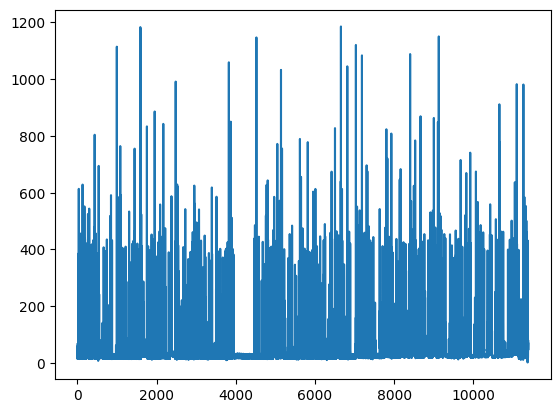

In [52]:
plt.plot(data_df['Summe'])
plt.show()

In [53]:
data_df['date'] = data_df.index
data_df.head()

,Timestamp,Summe,date
0,2014-03-12 07:00:00,66.321410,0
1,2014-03-12 08:00:00,14.977094,1
2,2014-03-12 09:00:00,27.099825,2
3,2014-03-12 10:00:00,14.787116,3
4,2014-03-12 11:00:00,27.785160,4


In [54]:
data_df['date'] = pd.to_datetime(data_df['date'])
data_df

,Timestamp,Summe,date
0,2014-03-12 07:00:00,66.321410,1970-01-01 00:00:00.000000000
1,2014-03-12 08:00:00,14.977094,1970-01-01 00:00:00.000000001
2,2014-03-12 09:00:00,27.099825,1970-01-01 00:00:00.000000002
3,2014-03-12 10:00:00,14.787116,1970-01-01 00:00:00.000000003
4,2014-03-12 11:00:00,27.785160,1970-01-01 00:00:00.000000004
...,...,...,...
11386,2015-06-29 17:00:00,80.591582,1970-01-01 00:00:00.000011386
11387,2015-06-29 18:00:00,52.420814,1970-01-01 00:00:00.000011387
11388,2015-06-29 19:00:00,46.189453,1970-01-01 00:00:00.000011388
11389,2015-06-29 20:00:00,58.697892,1970-01-01 00:00:00.000011389


In [66]:
import numpy as np
import math
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

def create_dataset(data, look_back=20):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back)])
        Y.append(data[i + look_back])
    return np.array(X), np.array(Y)

data_df = df_1_hour # Your data dataframe

min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
dataset = min_max_scaler.fit_transform(data_df['Summe'].values.reshape(-1, 1))

# split into train, validation, and test sets
train_size = int(len(dataset) * 0.7)
val_size = int(len(dataset) * 0.2)
test_size = len(dataset) - train_size - val_size

train_data = dataset[:train_size]
val_data = dataset[train_size:train_size+val_size]
test_data = dataset[train_size+val_size:]

# create train, validation, and test datasets
look_back = 20
x_train, y_train = create_dataset(train_data, look_back)
x_val, y_val = create_dataset(val_data, look_back)
x_test, y_test = create_dataset(test_data, look_back)

# reshape the input data
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_val = np.reshape(x_val, (x_val.shape[0], 1, x_val.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

# print the sizes of the datasets
print('Training Data Size:', train_data.shape)
print('Validation Data Size:', val_data.shape)
print('Testing Data Size:', test_data.shape)


Training Data Size: (7973, 1)
Validation Data Size: (2278, 1)
Testing Data Size: (1140, 1)


In [67]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [68]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
look_back = 20

# Check if GPU is available
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU is available.")
    print("List of physical GPUs:")
    for device in physical_devices:
        print(device)
else:
    print("GPU is not available. Using CPU instead.")
# Create the LSTM model
model = Sequential()

model.add(LSTM(20, input_shape=(1, look_back), return_sequences=True))
model.add(LSTM(10 ,return_sequences=True))
# model.add(LSTM(30,return_sequences=True))
# model.add(LSTM(20,return_sequences=True))

model.add(Dense(1))

# Compile the model
model.compile(loss='mean_absolute_error', optimizer='adam')

# Define early stopping callback
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(x_train, y_train,validation_data=(x_val, y_val), epochs=100, batch_size=32, verbose=2, callbacks=[early_stopping])

# Print model summary
print(model.summary())


GPU is available.
List of physical GPUs:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2023-05-29 17:33:40.435031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-29 17:33:40.436185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-29 17:33:40.437108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2023-05-29 17:33:40.882669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-29 17:33:40.884084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-29 17:33:40.885149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

249/249 - 4s - loss: 0.0335 - val_loss: 0.0319 - 4s/epoch - 18ms/step
Epoch 2/100
249/249 - 1s - loss: 0.0324 - val_loss: 0.0313 - 1s/epoch - 5ms/step
Epoch 3/100
249/249 - 1s - loss: 0.0322 - val_loss: 0.0311 - 1s/epoch - 5ms/step
Epoch 4/100
249/249 - 1s - loss: 0.0322 - val_loss: 0.0317 - 1s/epoch - 5ms/step
Epoch 5/100
249/249 - 1s - loss: 0.0321 - val_loss: 0.0315 - 1s/epoch - 6ms/step
Epoch 6/100
249/249 - 1s - loss: 0.0321 - val_loss: 0.0318 - 1s/epoch - 5ms/step
Epoch 7/100
249/249 - 1s - loss: 0.0321 - val_loss: 0.0310 - 1s/epoch - 5ms/step
Epoch 8/100
249/249 - 1s - loss: 0.0320 - val_loss: 0.0310 - 1s/epoch - 5ms/step
Epoch 9/100
249/249 - 1s - loss: 0.0320 - val_loss: 0.0309 - 1s/epoch - 5ms/step
Epoch 10/100
249/249 - 1s - loss: 0.0320 - val_loss: 0.0306 - 1s/epoch - 5ms/step
Epoch 11/100
249/249 - 1s - loss: 0.0319 - val_loss: 0.0315 - 1s/epoch - 5ms/step
Epoch 12/100
249/249 - 1s - loss: 0.0319 - val_loss: 0.0307 - 1s/epoch - 5ms/step
Epoch 13/100
249/249 - 1s - loss: 0.

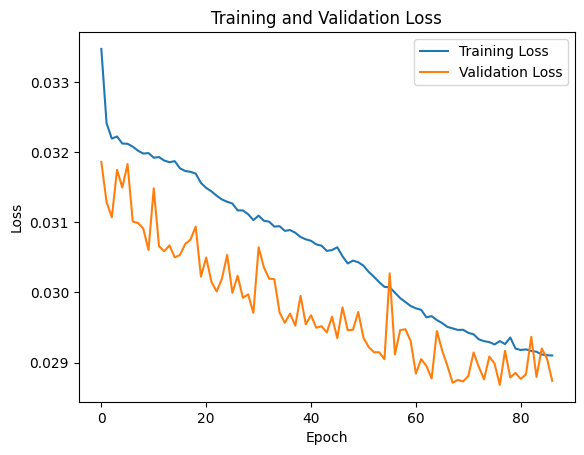

In [69]:
import matplotlib.pyplot as plt

# Get the training and validation loss values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training loss and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [70]:
trainPredict = model.predict(x_train)
# invert predictions
trainPredict_inversed = min_max_scaler.inverse_transform(trainPredict)





2023-05-29 17:35:50.941132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-29 17:35:50.943141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-29 17:35:50.944555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

249/249 [==============================] - 1s 2ms/step


ValueError: Found array with dim 3. None expected <= 2.

In [61]:
trainPredict

array([[[0.02132425]],

       [[0.02133293]],

       [[0.02136342]],

       ...,

       [[0.02153639]],

       [[0.02152913]],

       [[0.02138434]]], dtype=float32)

In [ ]:


trainY = min_max_scaler.inverse_transform([y_train])


In [ ]:


testPredict = min_max_scaler.inverse_transform(testPredict)
testY = min_max_scaler.inverse_transform([y_test])


In [ ]:


trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)


# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))



# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(min_max_scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [92]:
from sklearn.metrics import mean_absolute_error
 
Error_dataframe = {
    'Actual': [],
    'Predicted':[],
    'Pro_ratio' : []
}

prop_ratio_list = []
actual = []
predicted = []
for i in tqdm(range(x_test.shape[0])):
    test_x_i = np.reshape(x_test[i], (x_test[i].shape[0], 1, x_test[i].shape[1]))
    actual = min_max_scaler.inverse_transform(y_test[i].reshape(-1,1))
    actual =  actual.flatten().tolist()[0]
    predicted = model.predict(test_x_i)
    predicted =  min_max_scaler.inverse_transform(predicted.reshape(-1,1))
    predicted =  predicted.flatten().tolist()[0]
    prop_ratio  = predicted/actual
    
    Error_dataframe['Actual'].append(actual)
    Error_dataframe['Predicted'].append(predicted)
    Error_dataframe['Pro_ratio'].append(prop_ratio)
    
    
    

  0%|          | 0/1120 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 2/1120 [00:00<01:02, 17.94it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 4/1120 [00:00<01:03, 17.68it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 6/1120 [00:00<01:02, 17.90it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 9/1120 [00:00<00:56, 19.79it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 11/1120 [00:00<00:57, 19.19it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 14/1120 [00:00<00:55, 20.11it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 17/1120 [00:00<00:52, 20.88it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 20/1120 [00:00<00:50, 21.66it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 23/1120 [00:01<00:49, 22.12it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 26/1120 [00:01<00:49, 21.97it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 29/1120 [00:01<00:49, 22.21it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 32/1120 [00:01<00:48, 22.44it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 35/1120 [00:01<00:48, 22.14it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 38/1120 [00:01<00:48, 22.39it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▎         | 41/1120 [00:01<00:48, 22.40it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 44/1120 [00:02<00:50, 21.39it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 47/1120 [00:02<00:51, 20.99it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 50/1120 [00:02<00:49, 21.68it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 53/1120 [00:02<00:48, 21.90it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 56/1120 [00:02<00:47, 22.24it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 59/1120 [00:02<00:48, 21.74it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 62/1120 [00:02<00:47, 22.28it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▌         | 65/1120 [00:03<00:46, 22.69it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 68/1120 [00:03<00:46, 22.79it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 71/1120 [00:03<00:49, 21.13it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 74/1120 [00:03<00:46, 22.33it/s]

1/1 [==============================] - 0s 15ms/step


  7%|▋         | 77/1120 [00:03<00:44, 23.21it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 80/1120 [00:03<00:44, 23.21it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 83/1120 [00:03<00:44, 23.23it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 86/1120 [00:03<00:43, 23.77it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 89/1120 [00:04<00:42, 24.27it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 92/1120 [00:04<00:43, 23.49it/s]

1/1 [==============================] - 0s 15ms/step


  8%|▊         | 95/1120 [00:04<00:42, 24.15it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 98/1120 [00:04<00:41, 24.71it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 101/1120 [00:04<00:42, 23.80it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 104/1120 [00:04<00:41, 24.35it/s]

1/1 [==============================] - 0s 15ms/step


 10%|▉         | 107/1120 [00:04<00:40, 24.76it/s]

1/1 [==============================] - 0s 15ms/step


 10%|▉         | 110/1120 [00:04<00:40, 25.05it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 113/1120 [00:05<00:40, 24.69it/s]

1/1 [==============================] - 0s 15ms/step


 10%|█         | 116/1120 [00:05<00:42, 23.36it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█         | 119/1120 [00:05<00:41, 24.23it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█         | 122/1120 [00:05<00:40, 24.91it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 125/1120 [00:05<00:40, 24.73it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█▏        | 128/1120 [00:05<00:39, 25.03it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 131/1120 [00:05<00:38, 25.43it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 134/1120 [00:05<00:38, 25.35it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 137/1120 [00:05<00:38, 25.32it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▎        | 140/1120 [00:06<00:39, 25.02it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 143/1120 [00:06<00:38, 25.15it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 146/1120 [00:06<00:39, 24.87it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 149/1120 [00:06<00:39, 24.76it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▎        | 152/1120 [00:06<00:39, 24.54it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▍        | 155/1120 [00:06<00:38, 24.93it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 158/1120 [00:06<00:38, 24.69it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 161/1120 [00:06<00:38, 24.78it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 164/1120 [00:07<00:38, 24.86it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 167/1120 [00:07<00:38, 24.97it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▌        | 170/1120 [00:07<00:37, 25.33it/s]

1/1 [==============================] - 0s 14ms/step


 15%|█▌        | 173/1120 [00:07<00:37, 25.58it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 176/1120 [00:07<00:36, 25.79it/s]

1/1 [==============================] - 0s 15ms/step


 16%|█▌        | 179/1120 [00:07<00:37, 25.35it/s]

1/1 [==============================] - 0s 15ms/step


 16%|█▋        | 182/1120 [00:07<00:36, 25.47it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 185/1120 [00:07<00:37, 25.23it/s]

1/1 [==============================] - 0s 15ms/step


 17%|█▋        | 188/1120 [00:08<00:36, 25.39it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 191/1120 [00:08<00:37, 24.90it/s]

1/1 [==============================] - 0s 14ms/step


 17%|█▋        | 194/1120 [00:08<00:36, 25.33it/s]

1/1 [==============================] - 0s 15ms/step


 18%|█▊        | 197/1120 [00:08<00:35, 25.67it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 200/1120 [00:08<00:37, 24.57it/s]

1/1 [==============================] - 0s 15ms/step


 18%|█▊        | 203/1120 [00:08<00:37, 24.20it/s]

1/1 [==============================] - 0s 15ms/step


 18%|█▊        | 206/1120 [00:08<00:36, 24.88it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▊        | 209/1120 [00:08<00:36, 24.91it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 212/1120 [00:08<00:37, 24.22it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 215/1120 [00:09<00:37, 24.37it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 218/1120 [00:09<00:37, 24.14it/s]

1/1 [==============================] - 0s 15ms/step


 20%|█▉        | 221/1120 [00:09<00:37, 24.26it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 224/1120 [00:09<00:37, 23.89it/s]

1/1 [==============================] - 0s 15ms/step


 20%|██        | 227/1120 [00:09<00:37, 23.84it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 230/1120 [00:09<00:37, 23.86it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 233/1120 [00:09<00:37, 23.88it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 236/1120 [00:09<00:37, 23.75it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██▏       | 239/1120 [00:10<00:37, 23.61it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 242/1120 [00:10<00:37, 23.56it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 245/1120 [00:10<00:38, 22.50it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 248/1120 [00:10<00:39, 22.11it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 251/1120 [00:10<00:37, 22.93it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 254/1120 [00:10<00:40, 21.13it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 257/1120 [00:10<00:43, 20.00it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 260/1120 [00:11<00:43, 19.68it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 263/1120 [00:11<00:42, 20.40it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 266/1120 [00:11<00:40, 20.92it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 269/1120 [00:11<00:40, 20.89it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 272/1120 [00:11<00:39, 21.29it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 275/1120 [00:11<00:38, 21.80it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 278/1120 [00:11<00:38, 21.72it/s]

1/1 [==============================] - 0s 15ms/step


 25%|██▌       | 281/1120 [00:12<00:39, 21.29it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 284/1120 [00:12<00:37, 22.20it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 287/1120 [00:12<00:36, 22.58it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 290/1120 [00:12<00:37, 22.27it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 293/1120 [00:12<00:37, 22.32it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▋       | 296/1120 [00:12<00:37, 21.95it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 299/1120 [00:12<00:37, 21.69it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 302/1120 [00:13<00:37, 21.98it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 305/1120 [00:13<00:36, 22.32it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 308/1120 [00:13<00:37, 21.51it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 311/1120 [00:13<00:37, 21.62it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 314/1120 [00:13<00:37, 21.52it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 317/1120 [00:13<00:36, 21.86it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▊       | 320/1120 [00:13<00:35, 22.24it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 323/1120 [00:14<00:36, 21.75it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 326/1120 [00:14<00:37, 21.35it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 329/1120 [00:14<00:36, 21.73it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 332/1120 [00:14<00:36, 21.34it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 335/1120 [00:14<00:36, 21.63it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 338/1120 [00:14<00:38, 20.32it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 341/1120 [00:14<00:36, 21.06it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 344/1120 [00:15<00:36, 21.24it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 347/1120 [00:15<00:35, 21.58it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███▏      | 350/1120 [00:15<00:34, 22.26it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 353/1120 [00:15<00:34, 22.53it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 356/1120 [00:15<00:34, 22.03it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 359/1120 [00:15<00:34, 22.14it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 362/1120 [00:15<00:34, 21.76it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 365/1120 [00:15<00:35, 21.53it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 368/1120 [00:16<00:34, 21.73it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 371/1120 [00:16<00:36, 20.79it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 374/1120 [00:16<00:35, 21.01it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▎      | 377/1120 [00:16<00:35, 20.73it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 380/1120 [00:16<00:35, 20.85it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 383/1120 [00:16<00:35, 20.92it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 386/1120 [00:16<00:34, 21.34it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 389/1120 [00:17<00:34, 21.43it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 392/1120 [00:17<00:33, 21.54it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 395/1120 [00:17<00:33, 21.67it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 398/1120 [00:17<00:33, 21.57it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 401/1120 [00:17<00:35, 20.39it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 404/1120 [00:17<00:34, 20.99it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▋      | 407/1120 [00:17<00:33, 21.25it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 410/1120 [00:18<00:33, 20.97it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 413/1120 [00:18<00:34, 20.71it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 416/1120 [00:18<00:34, 20.61it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 419/1120 [00:18<00:34, 20.36it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 422/1120 [00:18<00:34, 20.37it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 425/1120 [00:18<00:35, 19.71it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 428/1120 [00:19<00:34, 20.14it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 431/1120 [00:19<00:33, 20.28it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 434/1120 [00:19<00:32, 21.03it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 437/1120 [00:19<00:32, 21.03it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 440/1120 [00:19<00:31, 21.80it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 443/1120 [00:19<00:31, 21.81it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 446/1120 [00:19<00:30, 21.93it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 449/1120 [00:19<00:30, 22.08it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 452/1120 [00:20<00:30, 22.04it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 455/1120 [00:20<00:32, 20.33it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 458/1120 [00:20<00:32, 20.66it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 461/1120 [00:20<00:31, 20.95it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 464/1120 [00:20<00:31, 21.04it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 467/1120 [00:20<00:30, 21.23it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 470/1120 [00:20<00:29, 21.75it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 473/1120 [00:21<00:29, 21.70it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▎     | 476/1120 [00:21<00:30, 21.40it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 479/1120 [00:21<00:32, 19.82it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 482/1120 [00:21<00:31, 20.57it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 485/1120 [00:21<00:30, 20.66it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 488/1120 [00:21<00:33, 18.79it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 491/1120 [00:22<00:32, 19.19it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 494/1120 [00:22<00:32, 19.03it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 496/1120 [00:22<00:33, 18.69it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 498/1120 [00:22<00:33, 18.77it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 500/1120 [00:22<00:32, 18.81it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 503/1120 [00:22<00:31, 19.86it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▌     | 506/1120 [00:22<00:30, 20.20it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 509/1120 [00:22<00:30, 20.18it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 512/1120 [00:23<00:31, 19.23it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 515/1120 [00:23<00:31, 19.07it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▋     | 518/1120 [00:23<00:29, 20.13it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 521/1120 [00:23<00:29, 20.25it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 524/1120 [00:23<00:28, 20.79it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 527/1120 [00:23<00:27, 21.49it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 530/1120 [00:23<00:27, 21.54it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 533/1120 [00:24<00:26, 21.99it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 536/1120 [00:24<00:25, 22.51it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 539/1120 [00:24<00:25, 22.61it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 542/1120 [00:24<00:25, 22.71it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▊     | 545/1120 [00:24<00:27, 21.02it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 548/1120 [00:24<00:26, 21.20it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 551/1120 [00:24<00:26, 21.12it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 554/1120 [00:25<00:27, 20.91it/s]

1/1 [==============================] - 0s 16ms/step


 50%|████▉     | 557/1120 [00:25<00:26, 21.30it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 560/1120 [00:25<00:25, 21.72it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 563/1120 [00:25<00:25, 21.57it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 566/1120 [00:25<00:25, 21.72it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 569/1120 [00:25<00:24, 22.07it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 572/1120 [00:25<00:25, 21.26it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████▏    | 575/1120 [00:26<00:28, 19.22it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 577/1120 [00:26<00:29, 18.23it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 579/1120 [00:26<00:29, 18.05it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 582/1120 [00:26<00:28, 19.12it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 585/1120 [00:26<00:27, 19.60it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▎    | 588/1120 [00:26<00:26, 20.04it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 591/1120 [00:26<00:26, 20.20it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 594/1120 [00:27<00:25, 20.32it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 597/1120 [00:27<00:25, 20.49it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 600/1120 [00:27<00:24, 21.16it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 603/1120 [00:27<00:23, 21.89it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 606/1120 [00:27<00:22, 22.43it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 609/1120 [00:27<00:24, 20.87it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 612/1120 [00:27<00:23, 21.34it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 615/1120 [00:28<00:23, 21.85it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 618/1120 [00:28<00:23, 21.74it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 621/1120 [00:28<00:23, 21.58it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 624/1120 [00:28<00:22, 22.04it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 627/1120 [00:28<00:22, 22.08it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 630/1120 [00:28<00:22, 21.98it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 633/1120 [00:28<00:22, 21.64it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 636/1120 [00:28<00:22, 21.95it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 639/1120 [00:29<00:21, 22.00it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 642/1120 [00:29<00:21, 21.92it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 645/1120 [00:29<00:21, 22.06it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 648/1120 [00:29<00:23, 20.42it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 651/1120 [00:29<00:23, 20.30it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 654/1120 [00:29<00:22, 20.49it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▊    | 657/1120 [00:29<00:22, 20.41it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 660/1120 [00:30<00:22, 20.64it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 663/1120 [00:30<00:22, 20.67it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 666/1120 [00:30<00:22, 20.58it/s]

1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 669/1120 [00:30<00:21, 21.41it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 672/1120 [00:30<00:20, 21.77it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 675/1120 [00:30<00:20, 21.20it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 678/1120 [00:30<00:20, 21.30it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 681/1120 [00:31<00:21, 20.69it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 684/1120 [00:31<00:21, 20.17it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████▏   | 687/1120 [00:31<00:22, 19.30it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 689/1120 [00:31<00:22, 19.03it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 691/1120 [00:31<00:22, 19.24it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 694/1120 [00:31<00:21, 20.16it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 697/1120 [00:31<00:20, 20.43it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 700/1120 [00:32<00:19, 21.19it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 703/1120 [00:32<00:19, 21.03it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 706/1120 [00:32<00:20, 20.27it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 709/1120 [00:32<00:20, 20.37it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▎   | 712/1120 [00:32<00:19, 21.05it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 715/1120 [00:32<00:19, 21.13it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 718/1120 [00:32<00:19, 20.80it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 721/1120 [00:33<00:19, 20.80it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 724/1120 [00:33<00:18, 21.29it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 727/1120 [00:33<00:19, 20.27it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 730/1120 [00:33<00:19, 19.80it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 732/1120 [00:33<00:19, 19.68it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 734/1120 [00:33<00:19, 19.58it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 736/1120 [00:33<00:19, 19.48it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 738/1120 [00:33<00:19, 19.49it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 740/1120 [00:34<00:21, 17.90it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 743/1120 [00:34<00:20, 18.85it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 745/1120 [00:34<00:19, 19.11it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 748/1120 [00:34<00:18, 20.11it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 751/1120 [00:34<00:18, 20.47it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 754/1120 [00:34<00:17, 21.17it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 757/1120 [00:34<00:16, 22.04it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 760/1120 [00:35<00:16, 22.11it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 763/1120 [00:35<00:16, 21.69it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 766/1120 [00:35<00:16, 22.02it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▊   | 769/1120 [00:35<00:15, 22.08it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 772/1120 [00:35<00:16, 21.55it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 775/1120 [00:35<00:15, 21.63it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 778/1120 [00:35<00:16, 20.46it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 781/1120 [00:36<00:17, 19.65it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 784/1120 [00:36<00:17, 19.74it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 786/1120 [00:36<00:16, 19.70it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 789/1120 [00:36<00:16, 20.35it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 792/1120 [00:36<00:15, 21.34it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 795/1120 [00:36<00:14, 22.08it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████▏  | 798/1120 [00:36<00:14, 22.75it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 801/1120 [00:36<00:13, 23.00it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 804/1120 [00:37<00:13, 22.66it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 807/1120 [00:37<00:13, 22.45it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 810/1120 [00:37<00:13, 23.28it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 813/1120 [00:37<00:12, 23.78it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 816/1120 [00:37<00:12, 23.47it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 819/1120 [00:37<00:12, 24.02it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 822/1120 [00:37<00:12, 24.30it/s]

1/1 [==============================] - 0s 15ms/step


 74%|███████▎  | 825/1120 [00:37<00:12, 24.42it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 828/1120 [00:38<00:12, 22.66it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 831/1120 [00:38<00:12, 22.82it/s]

1/1 [==============================] - 0s 15ms/step


 74%|███████▍  | 834/1120 [00:38<00:12, 23.45it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 837/1120 [00:38<00:11, 24.06it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▌  | 840/1120 [00:38<00:12, 23.30it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▌  | 843/1120 [00:38<00:11, 23.34it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 846/1120 [00:38<00:11, 23.22it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 849/1120 [00:38<00:11, 22.89it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 852/1120 [00:39<00:11, 23.28it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▋  | 855/1120 [00:39<00:11, 22.55it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 858/1120 [00:39<00:11, 22.68it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 861/1120 [00:39<00:11, 22.82it/s]

1/1 [==============================] - 0s 15ms/step


 77%|███████▋  | 864/1120 [00:39<00:11, 23.23it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 867/1120 [00:39<00:10, 23.76it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 870/1120 [00:39<00:10, 24.28it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 873/1120 [00:40<00:10, 24.21it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 876/1120 [00:40<00:10, 23.75it/s]

1/1 [==============================] - 0s 15ms/step


 78%|███████▊  | 879/1120 [00:40<00:10, 24.01it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 882/1120 [00:40<00:10, 22.63it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 885/1120 [00:40<00:10, 22.76it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 888/1120 [00:40<00:09, 23.47it/s]

1/1 [==============================] - 0s 16ms/step


 80%|███████▉  | 891/1120 [00:40<00:09, 23.97it/s]

1/1 [==============================] - 0s 16ms/step


 80%|███████▉  | 894/1120 [00:40<00:09, 24.14it/s]

1/1 [==============================] - 0s 16ms/step


 80%|████████  | 897/1120 [00:41<00:09, 24.61it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 900/1120 [00:41<00:08, 24.71it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 903/1120 [00:41<00:09, 24.07it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 906/1120 [00:41<00:09, 23.18it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 909/1120 [00:41<00:09, 23.02it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 912/1120 [00:41<00:09, 21.65it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 915/1120 [00:41<00:09, 21.96it/s]

1/1 [==============================] - 0s 15ms/step


 82%|████████▏ | 918/1120 [00:41<00:08, 22.52it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 921/1120 [00:42<00:08, 23.25it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▎ | 924/1120 [00:42<00:08, 23.70it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 927/1120 [00:42<00:08, 23.89it/s]

1/1 [==============================] - 0s 15ms/step


 83%|████████▎ | 930/1120 [00:42<00:07, 24.15it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 933/1120 [00:42<00:07, 24.35it/s]

1/1 [==============================] - 0s 15ms/step


 84%|████████▎ | 936/1120 [00:42<00:07, 24.56it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 939/1120 [00:42<00:07, 23.97it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 942/1120 [00:42<00:07, 22.81it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 945/1120 [00:43<00:07, 23.16it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 948/1120 [00:43<00:07, 23.37it/s]

1/1 [==============================] - 0s 15ms/step


 85%|████████▍ | 951/1120 [00:43<00:07, 23.98it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 954/1120 [00:43<00:06, 24.13it/s]

1/1 [==============================] - 0s 15ms/step


 85%|████████▌ | 957/1120 [00:43<00:06, 24.37it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 960/1120 [00:43<00:06, 24.28it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 963/1120 [00:43<00:06, 24.47it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▋ | 966/1120 [00:43<00:06, 23.31it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 969/1120 [00:44<00:06, 23.42it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 972/1120 [00:44<00:06, 23.44it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 975/1120 [00:44<00:06, 23.76it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 978/1120 [00:44<00:05, 24.28it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 981/1120 [00:44<00:05, 24.37it/s]

1/1 [==============================] - 0s 15ms/step


 88%|████████▊ | 984/1120 [00:44<00:05, 24.74it/s]

1/1 [==============================] - 0s 15ms/step


 88%|████████▊ | 987/1120 [00:44<00:05, 25.09it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 990/1120 [00:44<00:05, 23.58it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 993/1120 [00:45<00:05, 22.30it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 996/1120 [00:45<00:05, 22.17it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 999/1120 [00:45<00:05, 22.75it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 1002/1120 [00:45<00:05, 23.00it/s]

1/1 [==============================] - 0s 15ms/step


 90%|████████▉ | 1005/1120 [00:45<00:04, 23.26it/s]

1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 1008/1120 [00:45<00:04, 23.89it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 1011/1120 [00:45<00:04, 23.29it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 1014/1120 [00:46<00:04, 22.91it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 1017/1120 [00:46<00:04, 21.64it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 1020/1120 [00:46<00:04, 22.05it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 1023/1120 [00:46<00:04, 22.44it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 1026/1120 [00:46<00:04, 21.76it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 1029/1120 [00:46<00:04, 21.98it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 1032/1120 [00:46<00:03, 22.40it/s]

1/1 [==============================] - 0s 15ms/step


 92%|█████████▏| 1035/1120 [00:46<00:03, 22.91it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 1038/1120 [00:47<00:03, 22.94it/s]

1/1 [==============================] - 0s 15ms/step


 93%|█████████▎| 1041/1120 [00:47<00:03, 23.65it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 1044/1120 [00:47<00:03, 22.69it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 1047/1120 [00:47<00:03, 22.71it/s]

1/1 [==============================] - 0s 15ms/step


 94%|█████████▍| 1050/1120 [00:47<00:02, 23.37it/s]

1/1 [==============================] - 0s 15ms/step


 94%|█████████▍| 1053/1120 [00:47<00:02, 23.72it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 1056/1120 [00:47<00:02, 23.71it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 1059/1120 [00:47<00:02, 23.56it/s]

1/1 [==============================] - 0s 15ms/step


 95%|█████████▍| 1062/1120 [00:48<00:02, 23.83it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 1065/1120 [00:48<00:02, 23.70it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▌| 1068/1120 [00:48<00:02, 24.07it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 1071/1120 [00:48<00:03, 13.96it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 1074/1120 [00:48<00:02, 15.83it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 1077/1120 [00:49<00:02, 17.39it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 1080/1120 [00:49<00:02, 18.50it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 1083/1120 [00:49<00:01, 19.64it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 1086/1120 [00:49<00:01, 20.19it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 1089/1120 [00:49<00:01, 21.04it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 1092/1120 [00:49<00:01, 20.10it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 1095/1120 [00:49<00:01, 20.52it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 1098/1120 [00:50<00:01, 21.04it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 1101/1120 [00:50<00:00, 21.21it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 1104/1120 [00:50<00:00, 21.60it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 1107/1120 [00:50<00:00, 22.00it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 1110/1120 [00:50<00:00, 22.15it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 1113/1120 [00:50<00:00, 21.30it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 1116/1120 [00:50<00:00, 20.37it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 1119/1120 [00:51<00:00, 20.46it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 1120/1120 [00:51<00:00, 21.94it/s]


In [93]:
from sklearn.metrics import mean_absolute_percentage_error , mean_absolute_error
Error_df = pd.DataFrame.from_dict(Error_dataframe)
print('Mean Absolute Percentage Error : ',mean_absolute_percentage_error(Error_df['Actual'] , Error_df['Predicted'] ))
print('Mean Absolute Error : ',mean_absolute_error(Error_df['Actual'] , Error_df['Predicted'] ))

Mean Absolute Percentage Error :  0.330126616703543
Mean Absolute Error :  32.006764168020446


In [94]:
Error_df

,Actual,Predicted,Pro_ratio
0,30.400977,28.643713,0.942197
1,37.112743,28.319099,0.763056
2,144.535865,29.701042,0.205493
3,296.136337,64.864197,0.219035
4,251.992852,170.327866,0.675923
...,...,...,...
1115,80.591582,29.490396,0.365924
1116,52.420814,34.453331,0.657245
1117,46.189453,37.650257,0.815127
1118,58.697892,38.182827,0.650497


In [95]:
Error_df.to_csv('Error.csv',index=False)

In [97]:
model_name = 'RNN'
# Create a subplot with two rows and one column
fig = go.Figure()

fig.add_trace(
go.Scatter(
    x=Error_df.index,
    y=Error_df['Predicted'],
    name='Predicted',
    mode='lines+markers'
))

# Add a trace for actual values
fig.add_trace(
    go.Scatter(
        x=Error_df.index,
        y=Error_df['Actual'],
        name='Actual Values',
        mode='lines+markers'
    )
)


# Update xaxis properties
fig.update_xaxes(title_text='Time')

# Update yaxis properties
fig.update_yaxes(title_text='Summe')

# Update title and height
fig.update_layout(
    title=f'Forecasting using ',
    height=500,
    width=1000
)

# Save the plot as an HTML file
fig.show()
!mkdir 'Visualization_models_results'
fig.write_html(f'Visualization_models_results/forecasting_using_{model_name}'+'.html')


mkdir: cannot create directory ‘Visualization_models_results’: File exists
